# Human Tumor Analysis


In [1]:
import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Filter and concatenate

In [3]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM']


Dropkick is a tool to get rid of empty and low-quality droplets based on ambient reads. It should be applied to each sample separately, so we will apply first and then concantenate the data into one AnnData object.

In [47]:
adata = scv.datasets.pancreas()
adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

Filtered out 12261 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


## Cell Cycle Regression

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


... storing 'phase' as categorical


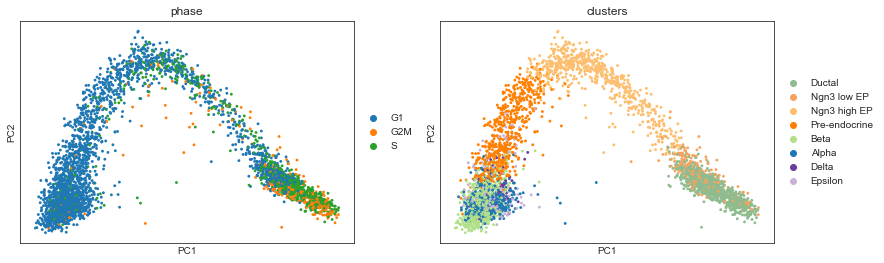

In [48]:
sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','clusters'])

In [19]:
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
# sc.pp.scale(adata)

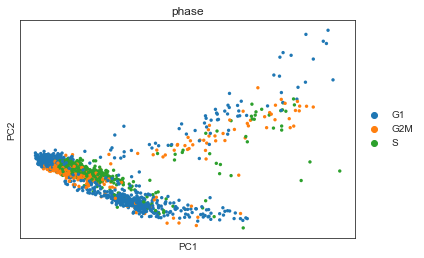

In [20]:
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color='phase')

# Dimensionality Reduction and RNA Velocity

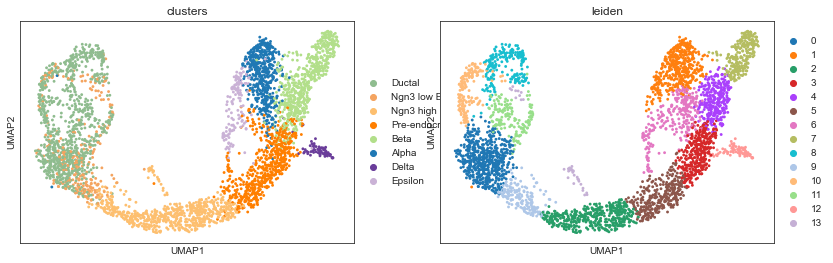

In [49]:
import matplotlib.pyplot as plt
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata, color = ['clusters','leiden'], ncols = 3)


## Calculating Velocity

In [59]:
scv.pp.moments(adata)
scv.tl.velocity(adata, mode = 'stochastic')
scv.tl.velocity_graph(adata)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:43) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


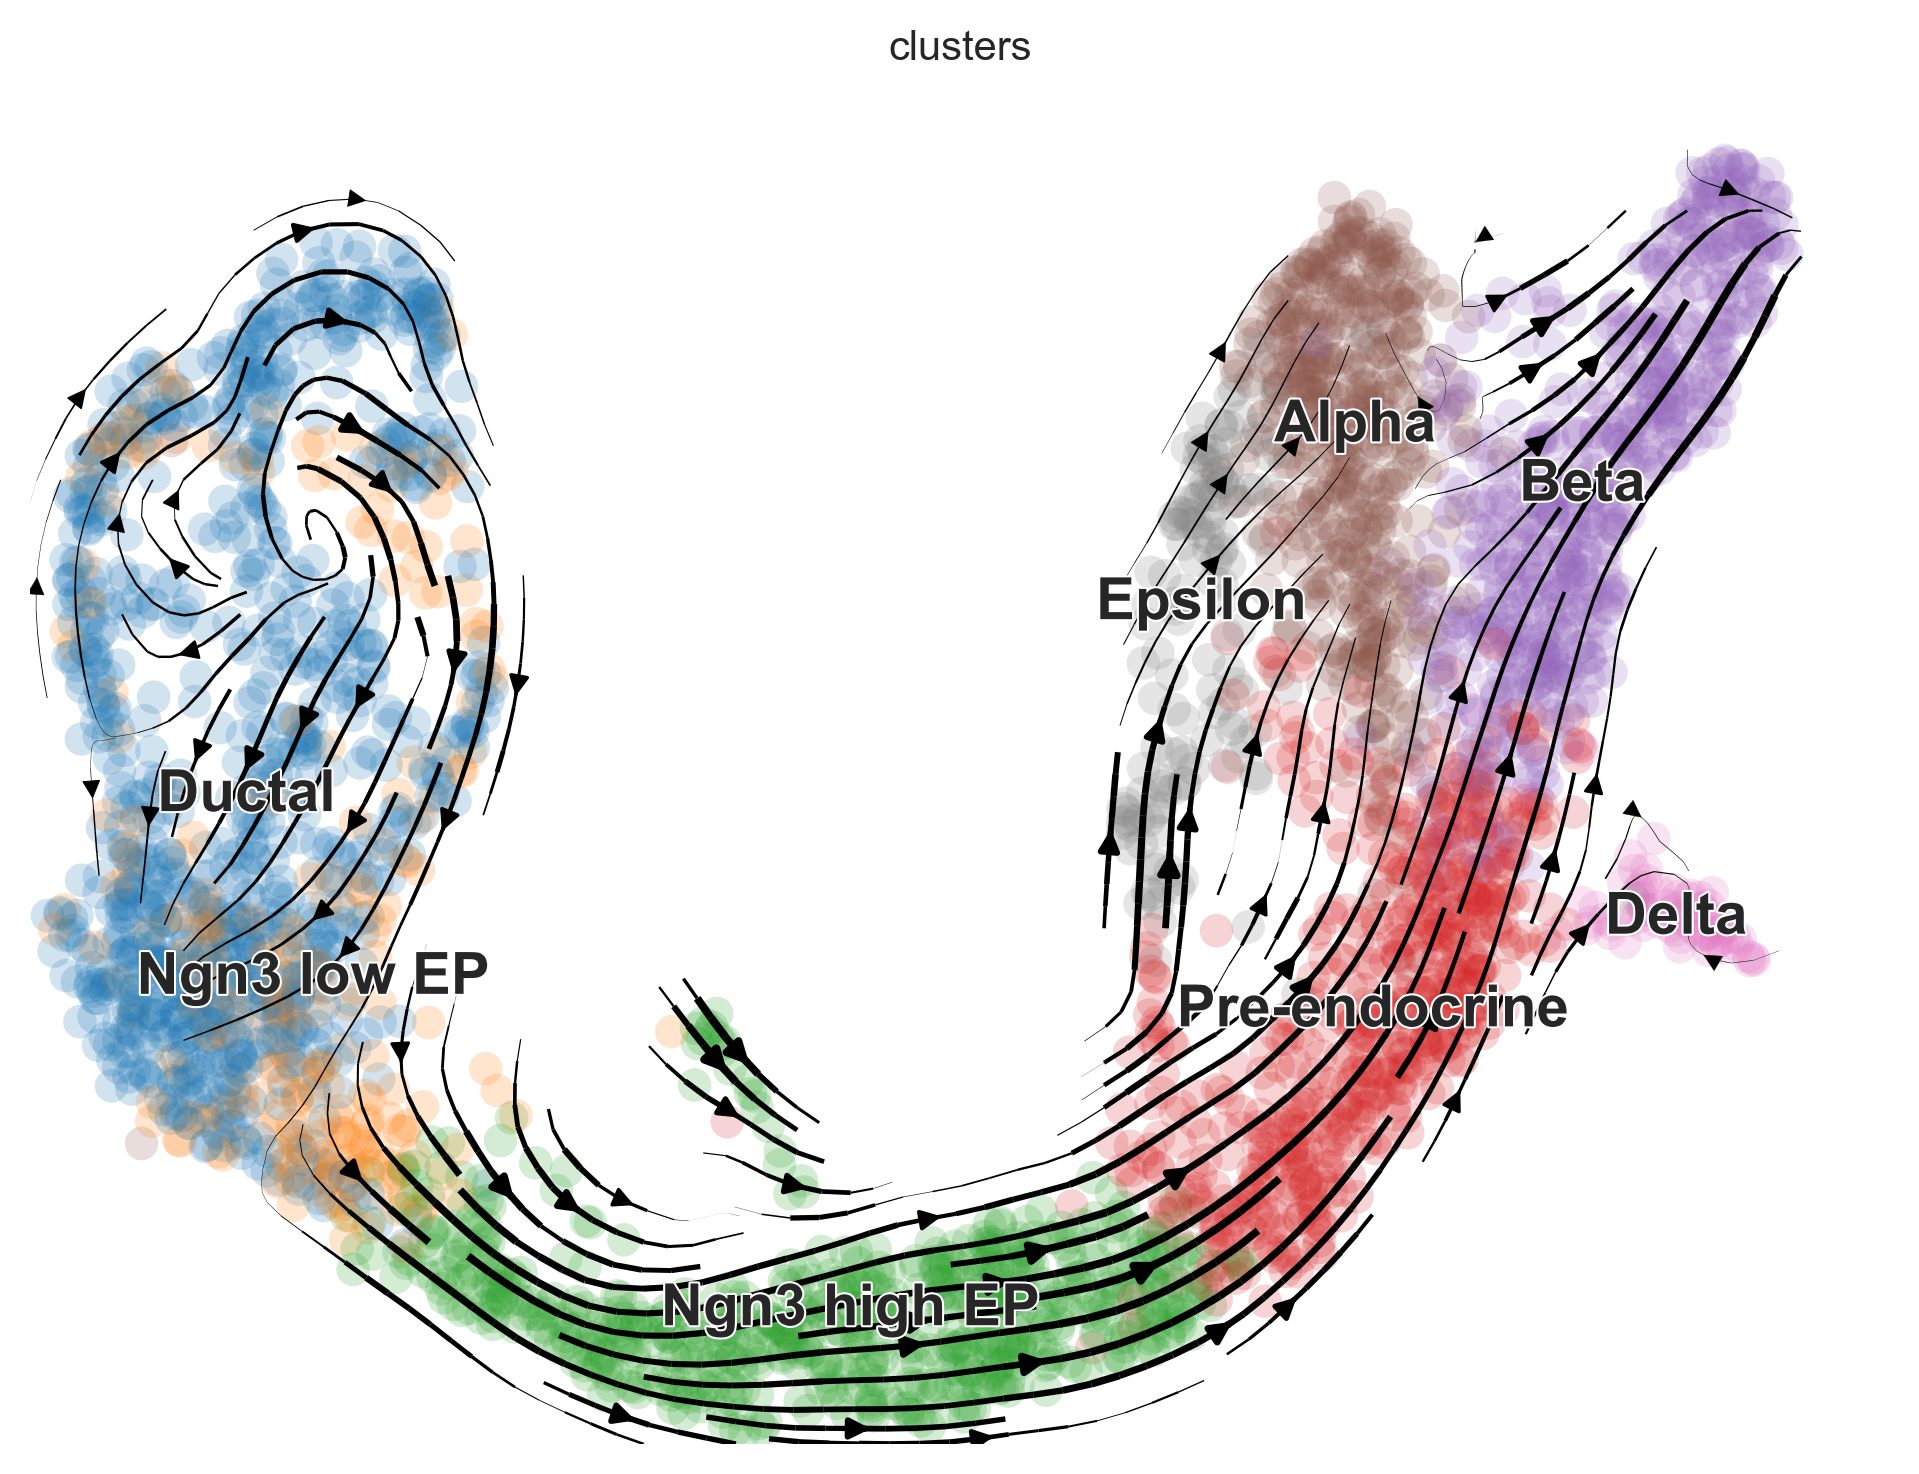

In [60]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = ['clusters'], legend_loc = 'on data',
                               figsize = (8,6), legend_fontsize=14, 
                                 dpi = 300, alpha=.2, palette='muted')


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


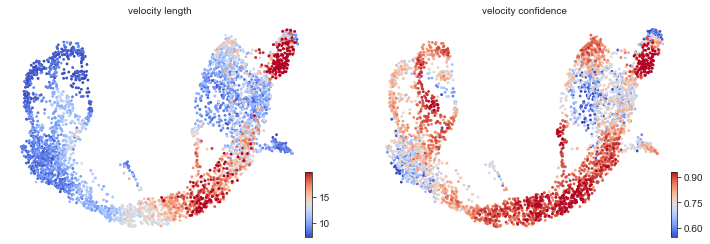

In [61]:
scv.tl.velocity_confidence(adata)

keys = 'velocity_length', 'velocity_confidence'  
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], basis = 'umap')

# Pseudotime and plasticity

We would like to see if we can get the same results as Ireland et al. did for their pseudotime analysis. To run Monocle2, we need the R interface `rpy2`. We'll also use the pseudotime inference within scvelo for comparison.

### Velocity pseudotime

computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


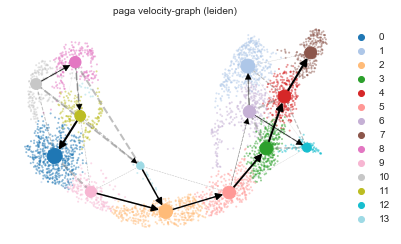

In [62]:
mb.ps.velocity_paga(adata, basis='umap')

### Calculate plasticity using CTrP

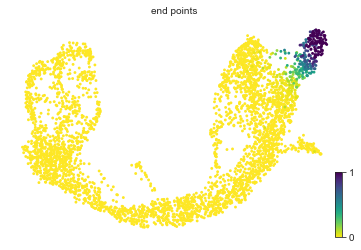

In [66]:
scv.pl.umap(adata, color = 'end_points')

In [64]:
mb.ps.ctrp(adata, self_transitions=False, adata_dist='X_pca')

computing terminal states
Eigenvalues:  [1.0000005]
(3696, 1)
    identified 1 end points
Dropping absorbing rows for fundamental matrix...
(3618, 3618)
Calculating fate...
Calculating distances...
Calculating inner product...


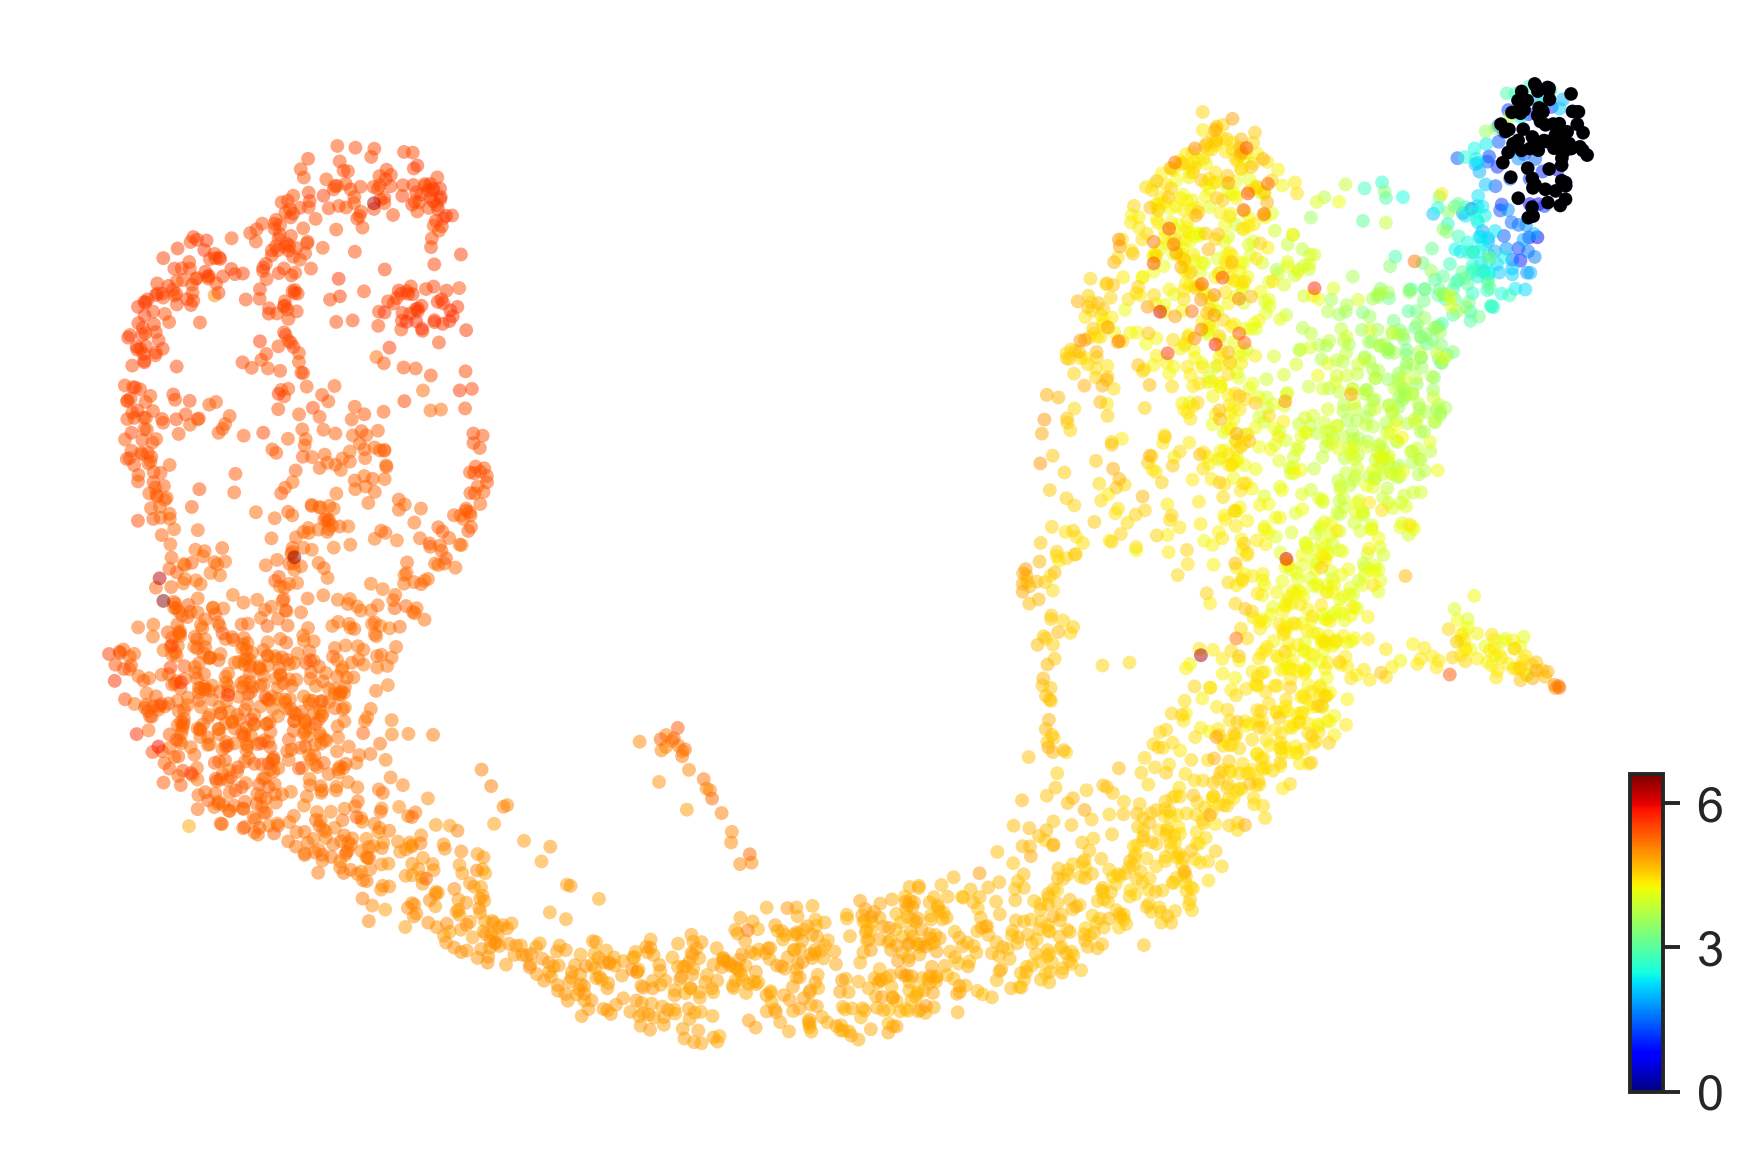

In [65]:
mb.pl.ctrp(adata, basis = 'umap')

In [70]:
df = adata.obs[['clusters','ctrp']].pivot(columns='clusters')
df.columns = df.columns.droplevel(0)
sorting =df.mean().sort_values(ascending = False).index.values

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

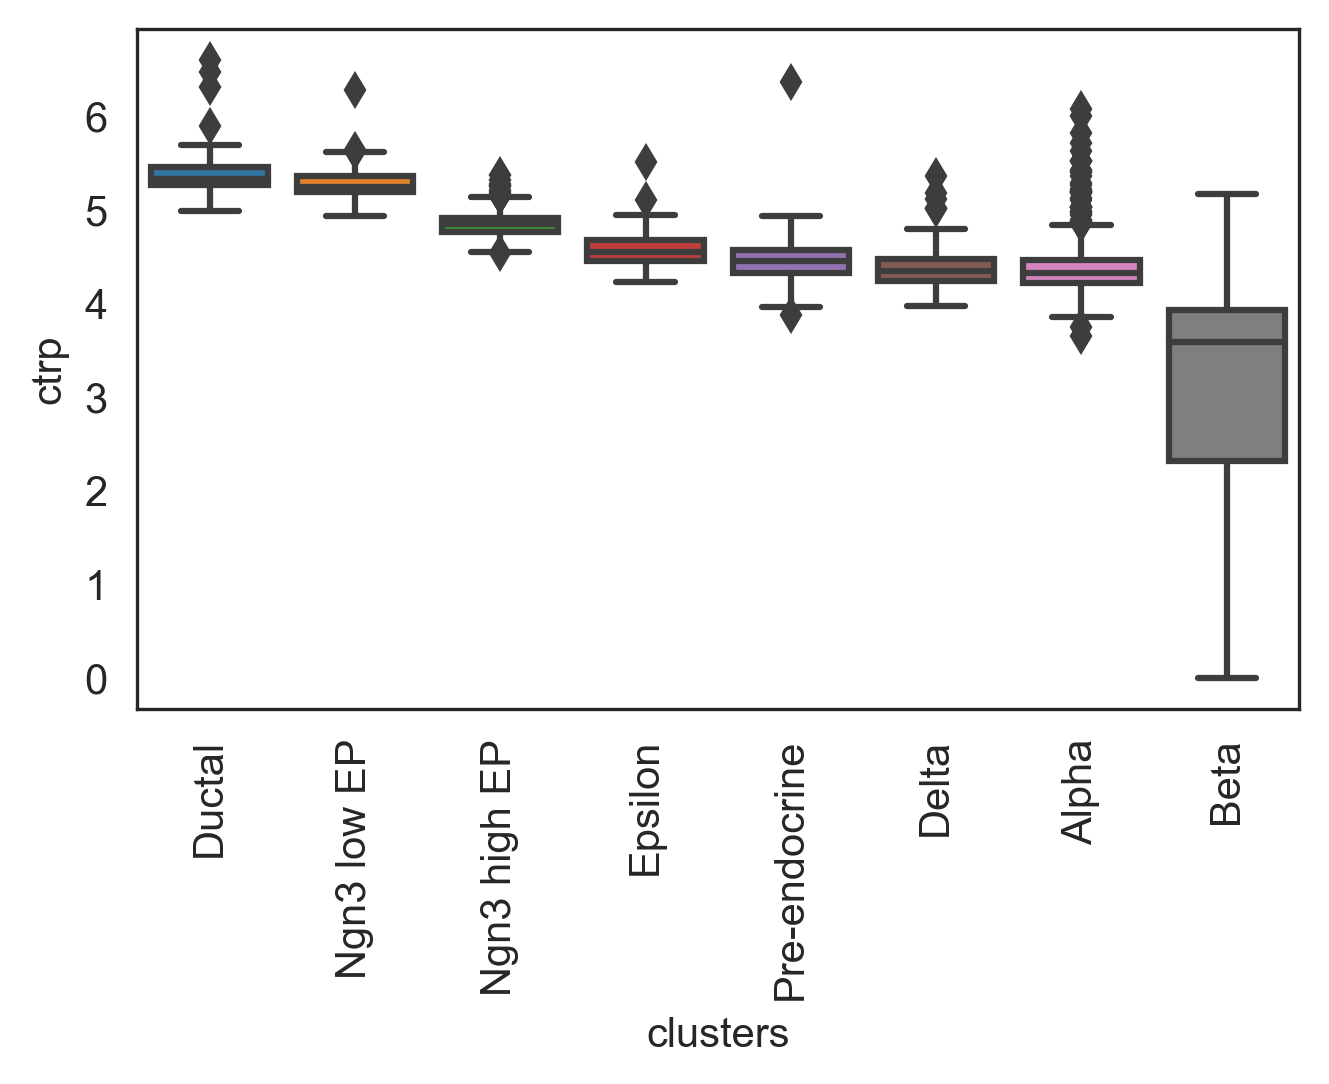

In [73]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
plt.figure(figsize=(5,3))

sns.boxplot(data = adata.obs, x = 'clusters',y='ctrp', order=sorting)
plt.xticks(rotation = 90)

# Dentate Gyrus

In [4]:
adata = scv.datasets.dentategyrus()
adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

Filtered out 795 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


## Cell Cycle Regression

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


... storing 'phase' as categorical


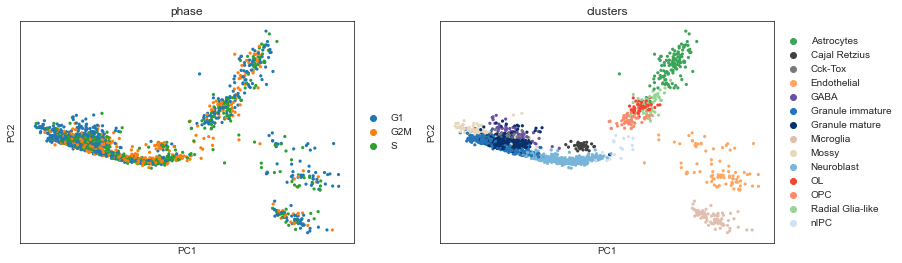

In [5]:
sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','clusters'])

In [6]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

# Dimensionality Reduction and RNA Velocity

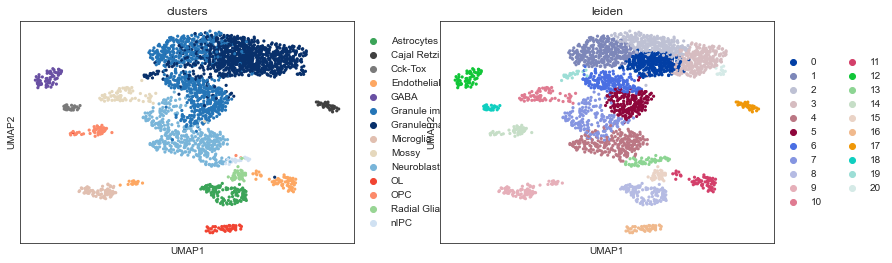

In [7]:
import matplotlib.pyplot as plt
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 5, min_dist = 1)
sc.pl.umap(adata, color = ['clusters','leiden'], ncols = 3)


## Calculating Velocity

In [8]:
scv.pp.moments(adata)
scv.tl.velocity(adata, mode = 'stochastic')
scv.tl.velocity_graph(adata)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


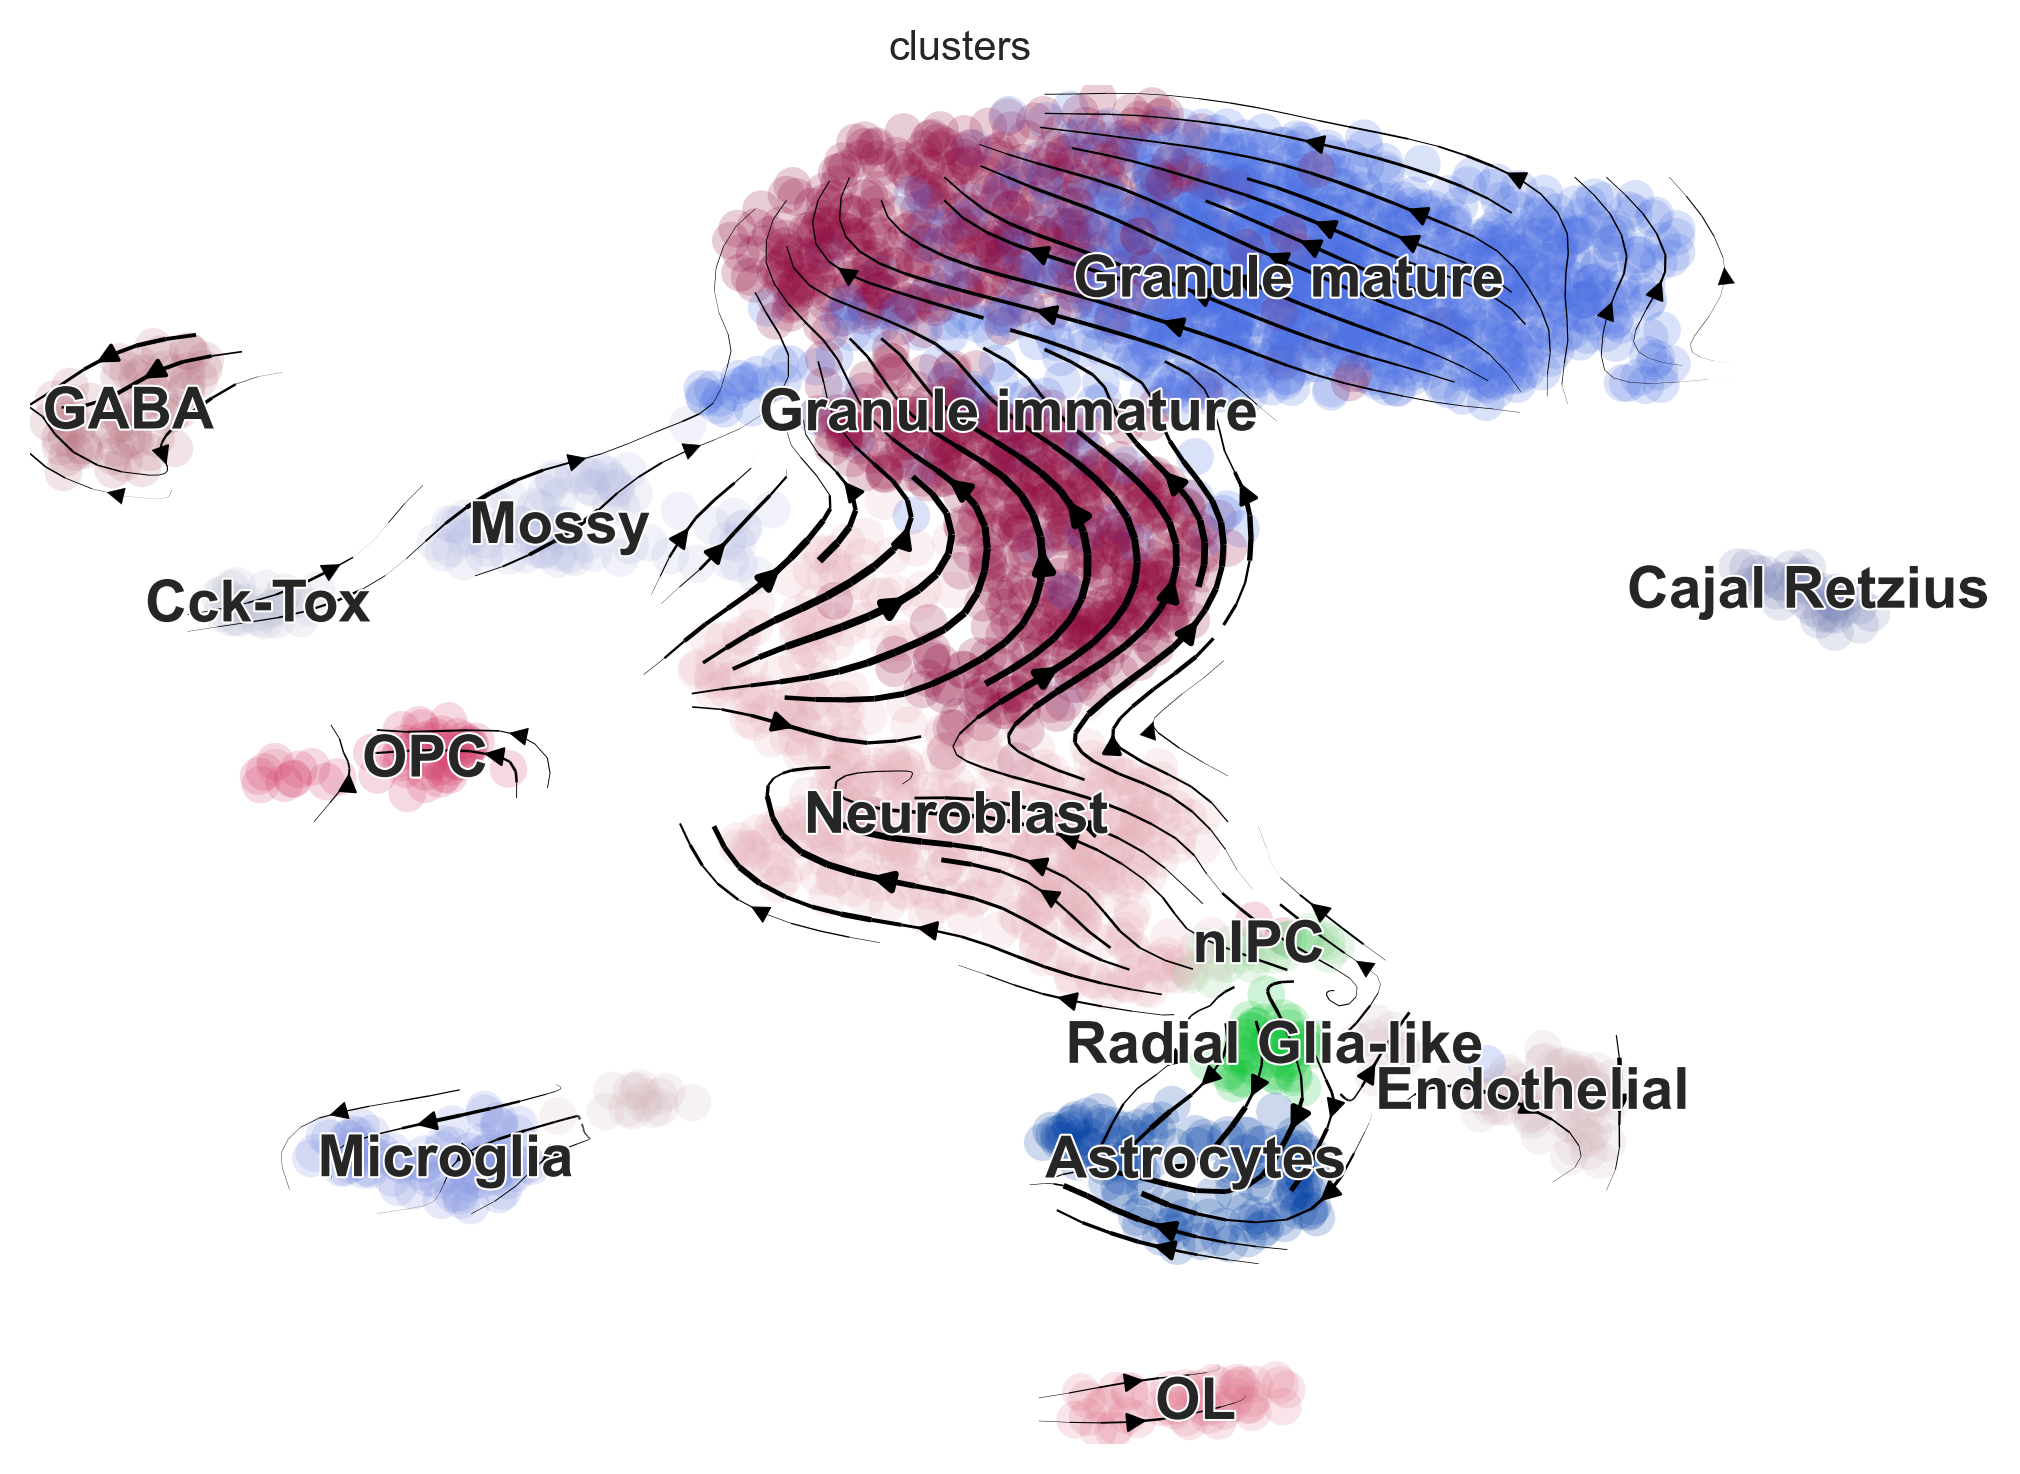

In [9]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = ['clusters'], legend_loc = 'on data',
                               figsize = (8,6), legend_fontsize=14, 
                                 dpi = 300, alpha=.2, palette='muted')


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


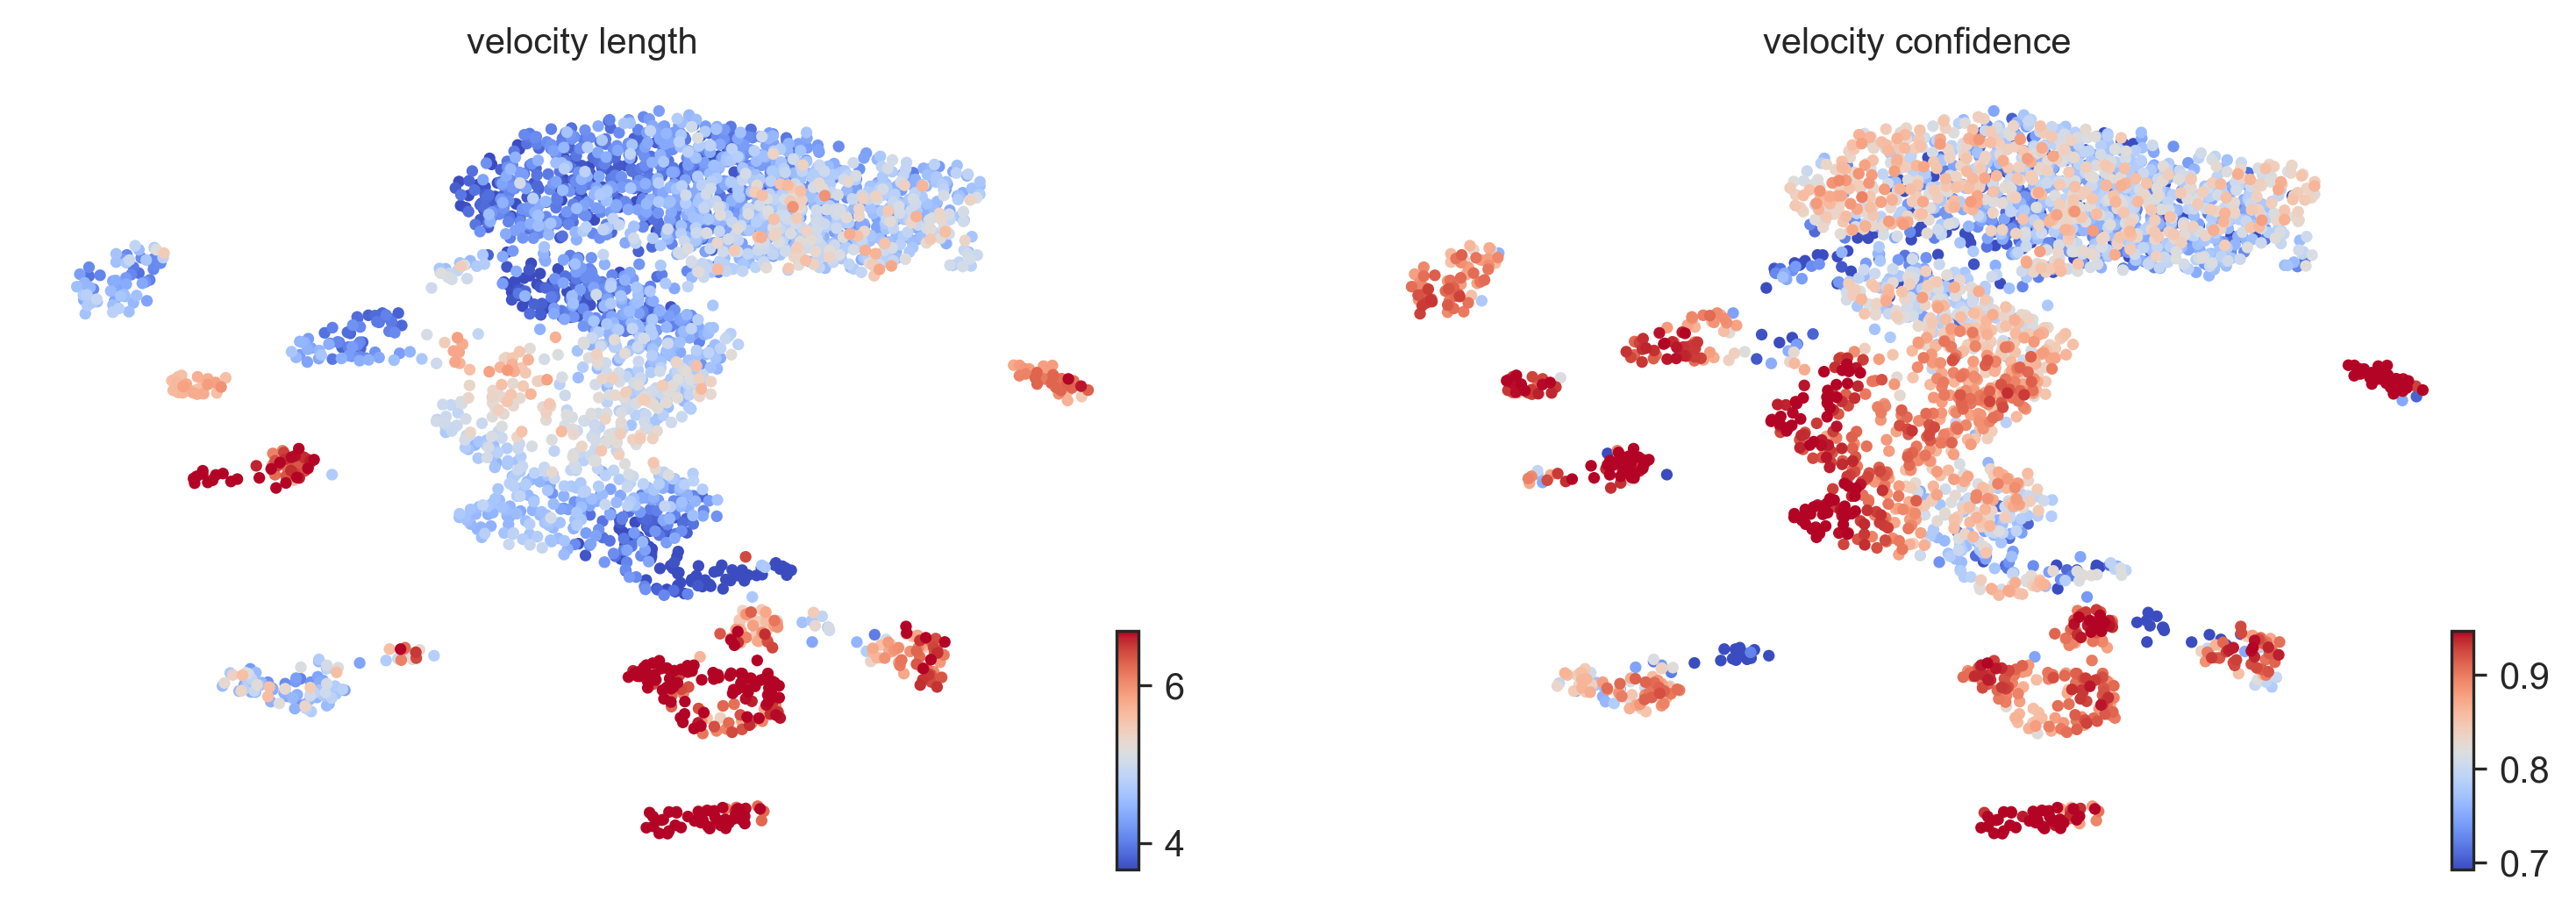

In [18]:
scv.tl.velocity_confidence(adata)

keys = 'velocity_length', 'velocity_confidence'  
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], basis = 'umap')

# Pseudotime and plasticity

We would like to see if we can get the same results as Ireland et al. did for their pseudotime analysis. To run Monocle2, we need the R interface `rpy2`. We'll also use the pseudotime inference within scvelo for comparison.

### Velocity pseudotime

computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


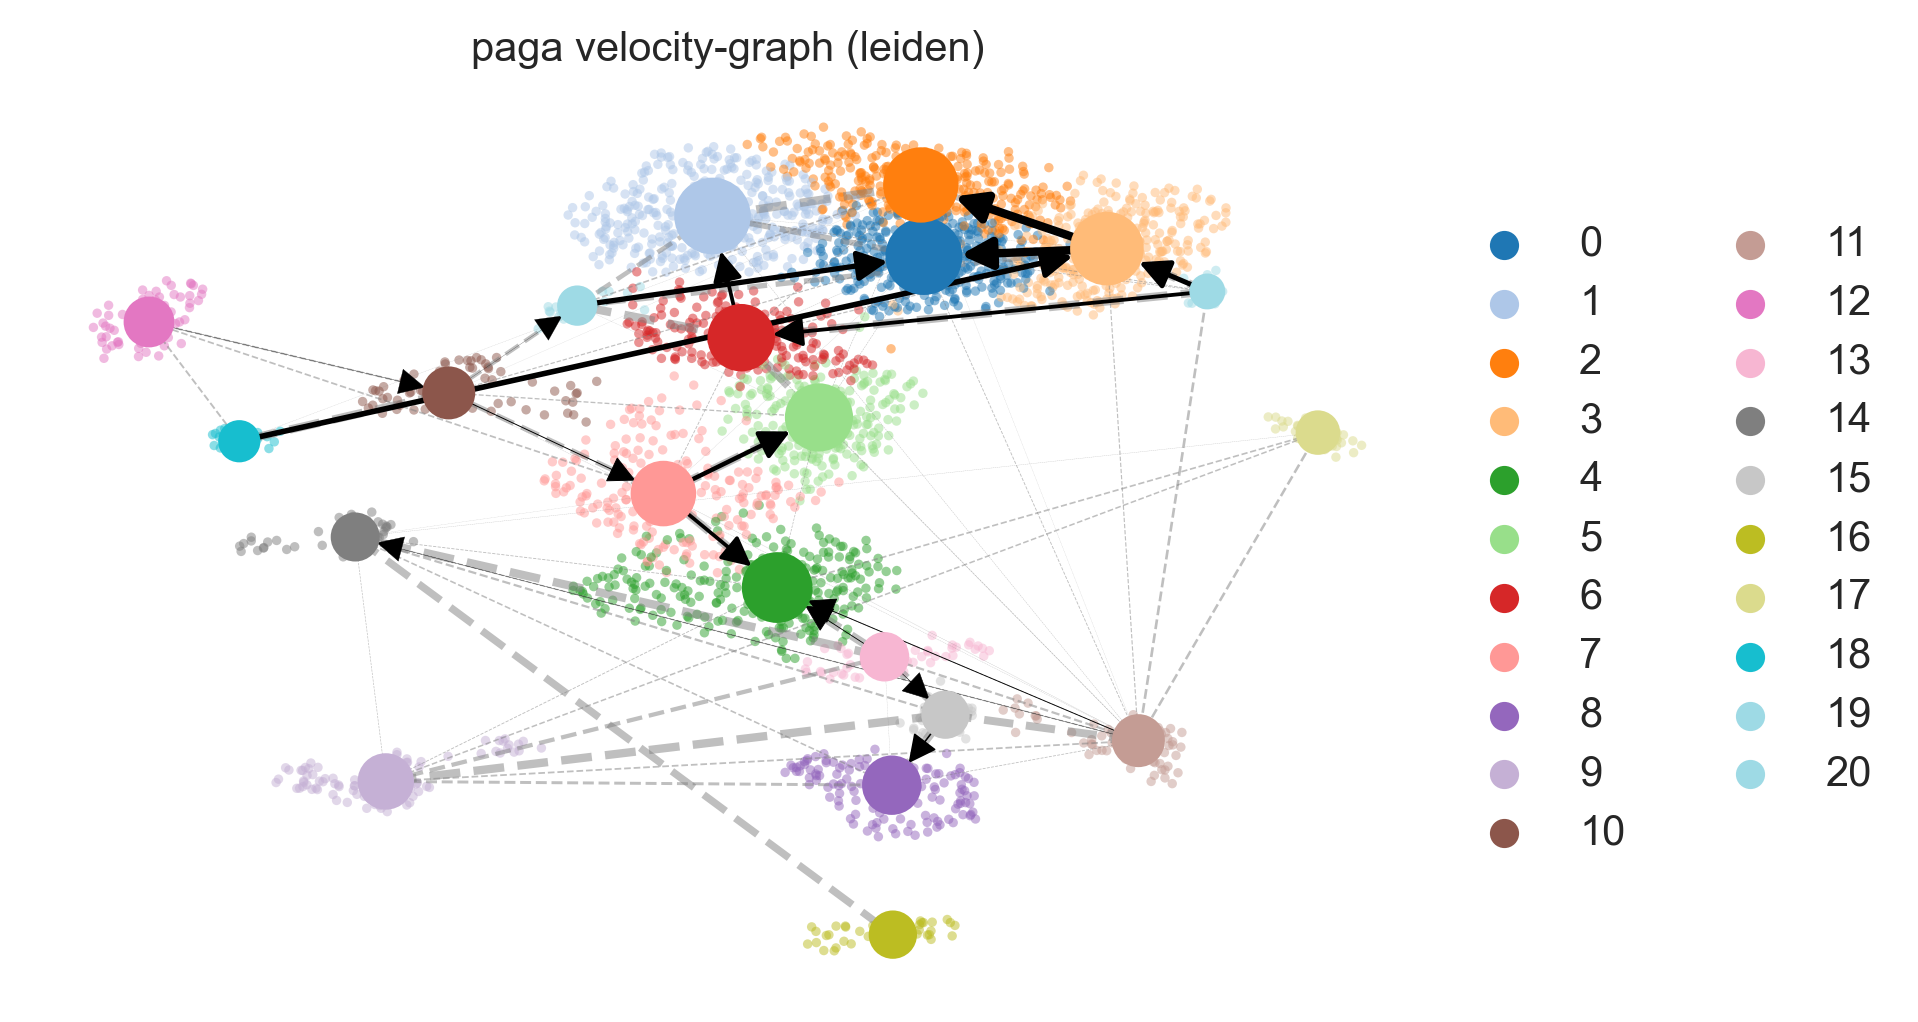

In [19]:
scv.tl.velocity_pseudotime(adata)
mb.ps.velocity_paga(adata, basis='umap')

### Calculate plasticity using CTrP

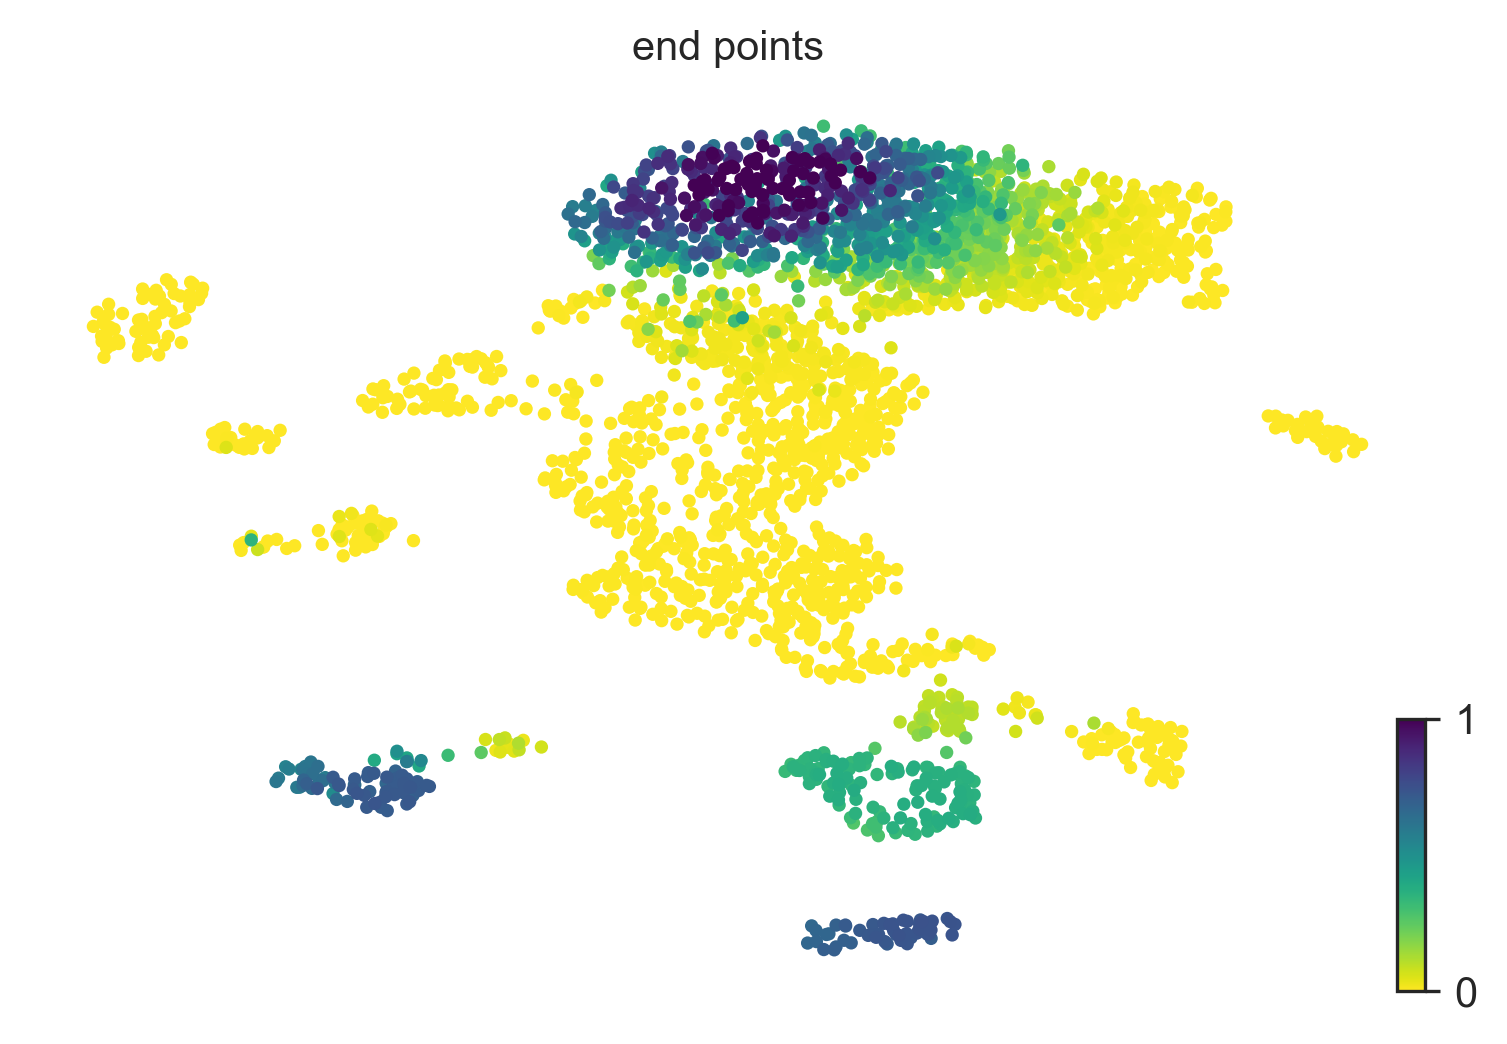

In [32]:
scv.pl.umap(adata, color = 'end_points')

In [50]:
mb.ps.ctrp(adata, self_transitions=False, adata_dist='X_pca', eps= 0.01)

computing terminal states
Eigenvalues:  [1.0000247  1.0000006  0.99999416 0.99861467]
(2930, 4)
    identified 4 end points
Dropping absorbing rows for fundamental matrix...
(2857, 2857)
Calculating fate...
Calculating distances...
Calculating inner product...


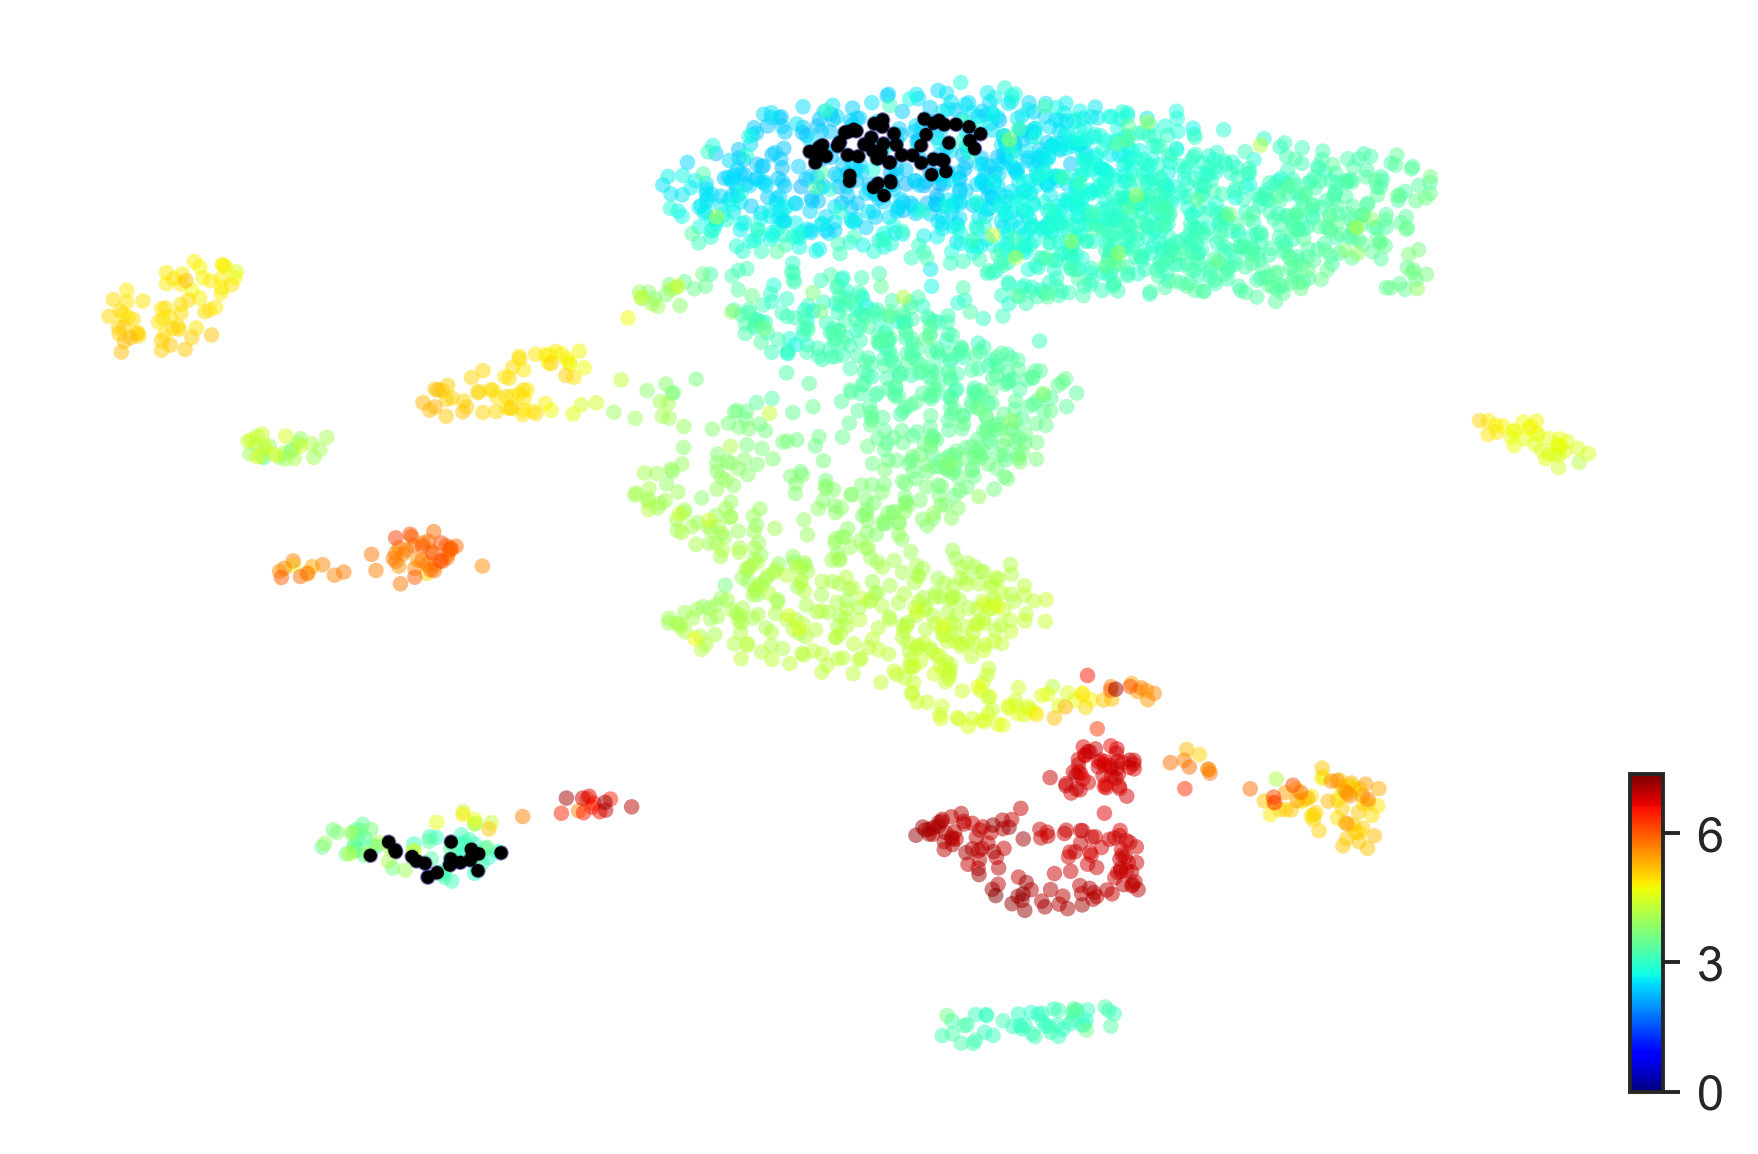

In [66]:
mb.pl.ctrp(adata, basis = 'umap', figsize=(6,4))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Astrocytes'),
  Text(1, 0, 'Radial Glia-like'),
  Text(2, 0, 'OPC'),
  Text(3, 0, 'Endothelial'),
  Text(4, 0, 'nIPC'),
  Text(5, 0, 'GABA'),
  Text(6, 0, 'Mossy'),
  Text(7, 0, 'Cajal Retzius'),
  Text(8, 0, 'Neuroblast'),
  Text(9, 0, 'Cck-Tox'),
  Text(10, 0, 'Microglia'),
  Text(11, 0, 'OL'),
  Text(12, 0, 'Granule immature'),
  Text(13, 0, 'Granule mature')])

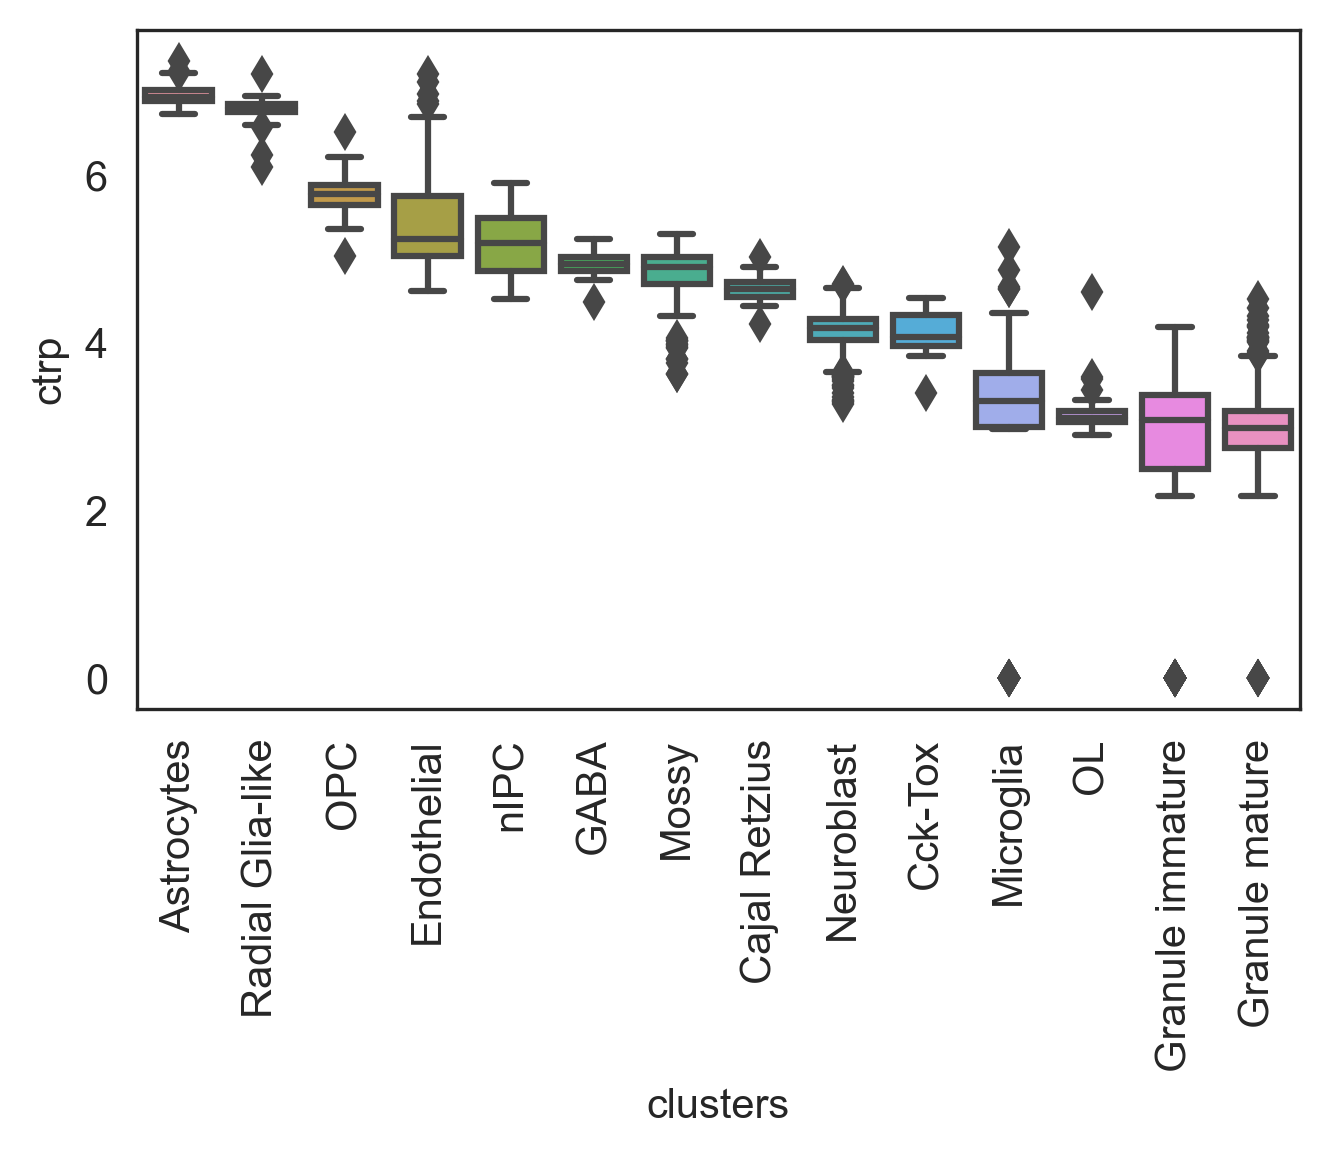

In [65]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
df = adata.obs[['clusters','ctrp']].pivot(columns='clusters')
df.columns = df.columns.droplevel(0)
sorting =df.median().sort_values(ascending = False).index.values
plt.figure(figsize=(5,3))

ax = sns.boxplot(data = adata.obs, x = 'clusters',y='ctrp', order=sorting)
# add_stat_annotation(ax, data=adata.obs, x='clusters',y = 'ctrp',
#                     order = sorting,
#                     box_pairs=[('Astrocytes','Radial Glia-like'),
#                               ('Radial Glia-like','OPC'), ("OPC", "Endothelial"),
#                                ("Endothelial", "nIPC")],
#                     test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
plt.xticks(rotation = 90)